In [1]:
# Perform Imports

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()


# reflect the tables
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
for row in session.query(Measurement, Measurement.date).limit(5).all():
    print(row)

    


(<sqlalchemy.ext.automap.measurement object at 0x0000020AB11142E0>, '2010-01-01')
(<sqlalchemy.ext.automap.measurement object at 0x0000020AB1114220>, '2010-01-02')
(<sqlalchemy.ext.automap.measurement object at 0x0000020AB1114100>, '2010-01-03')
(<sqlalchemy.ext.automap.measurement object at 0x0000020AB11145B0>, '2010-01-04')
(<sqlalchemy.ext.automap.measurement object at 0x0000020AB1114610>, '2010-01-06')


In [9]:
# Find the most recent date in the data set.
most_rec_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Most Recent Date: {most_rec_date[0]}")

Most Recent Date: 2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recentdate = dt.datetime.strptime(most_rec_date[0], '%Y-%m-%d')
startdate = dt.date(recentdate.year -1, recentdate.month, recentdate.day)
startdate

# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= startdate).all()



# Save the query results as a Pandas DataFrame and set the index to the date column
precip = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precip = precip.dropna(how='any')  
precip = precip.set_index("Date")

# Sort the dataframe by date
precip = precip.sort_values(["Date"], ascending=True)

 

# Set Date column as the index for charting

precip.head()



,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


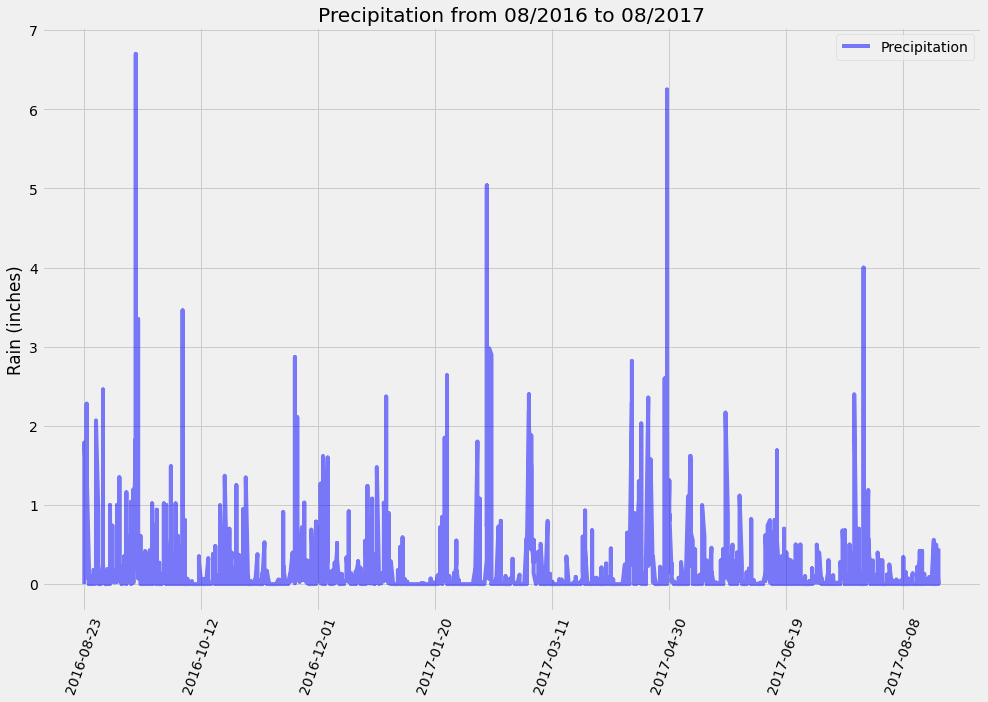

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data

date = precip.index.tolist()
rain = precip['Precipitation'].tolist()

plt.figure(figsize=(15,10))
plt.plot(date,rain,color='blue', alpha=0.5,label='Precipitation')

major_ticks = np.arange(0,366,50)
degrees = 70
plt.xticks(major_ticks, rotation = degrees)

plt.title(f"Precipitation from 08/2016 to 08/2017")
 
plt.ylabel("Rain (inches)")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
 
sel = [Measurement.station,func.count(Measurement.id)]
stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
stations    
    

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_stat = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_active_stat

(54.0, 85.0, 71.66378066378067)

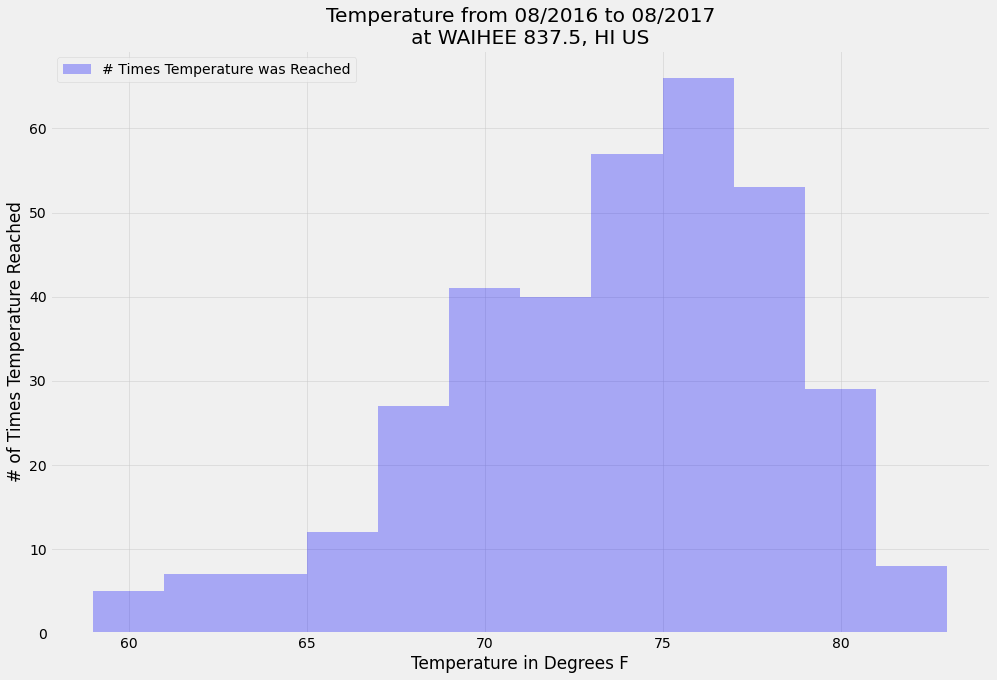

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station

tempresult = session.query(Measurement.tobs).\
    filter(Measurement.station == stations[0][0]).\
    filter(Measurement.date >= startdate).all()
temperatures = list(np.ravel(tempresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = stations_desc.loc[stations_desc["Station"] == stations[0][0],"Name"].tolist()[0]

# Plot the results as a histogram

plt.figure(figsize=(15,10))
plt.hist(temperatures, bins=12,rwidth=3.0, color = 'blue', alpha =.3, label='# Times Temperature was Reached')
plt.grid(axis='both', alpha=0.50)
plt.ylabel('# of Times Temperature Reached')
plt.xlabel('Temperature in Degrees F')
plt.title(f"Temperature from 08/2016 to 08/2017\n   at {station_name}")
plt.legend()


# Close session

In [17]:
# Close Session
session.close()